In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import tqdm
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import wandb
import seaborn as sns
import sys
sys.path.append('/Users/mariayuffa/semester-project-II')

from utils import *
from model import *

# for tensorboard
from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter()

wandb.init(project="Maria_protein_interactions")

# Using embedding
In this experiment, we sample data not only from uniform distribution but from variety of distributions. We then use this data for encoder and feed its output throught cross-attention mechanism to the decoder. The decoder takes the sequence with missing tokens and tries to fill in the gaps.

### Architecture
- We use multihead attention for the encoder and vanilla attention for the decoder.
- In the encoder, before splitting heads I "merge" the 5 sequences through linear layer.

In [45]:
import os
print(os.getcwd())

/Users/mariayuffa/semester-project-3


In [46]:
'''
samples_train = np.load("data/examples/data_enc_example_big.npy")
#add_true = np.load("data/data_enc_example_new_add.npy")
#add_true = add_true.reshape(1, add_true.shape[0], add_true.shape[1])
#samples_train = np.concatenate((samples_train,add_true), axis=0)

samples_train = samples_train.reshape(samples_train.shape[0]*samples_train.shape[1], samples_train.shape[-1])
samples_train = (samples_train+1)/2

chains_train = np.load("data/examples/data_dec_example_big.npy")
chains_train = (chains_train+1)/2

J = np.load("data/contact_mat/J_enc_big.npy")

print("Loaded train encoder sequences:", samples_train.shape)
print("Loaded train decoder sequences:", chains_train.shape)
'''
samples_train = np.load("data/examples/data_enc_example_new.npy")
#add_true = np.load("data/data_enc_example_new_add.npy")
#add_true = add_true.reshape(1, add_true.shape[0], add_true.shape[1])
#samples_train = np.concatenate((samples_train,add_true), axis=0)

samples_train = samples_train.reshape(samples_train.shape[0]*samples_train.shape[1], samples_train.shape[-1])
samples_train = (samples_train+1)/2

chains_train = np.load("data/examples/train_example_new.npy")
chains_train = (chains_train+1)/2

J = np.load("data/contact_mat/J_example_new.npy")

print("Loaded train encoder sequences:", samples_train.shape)
print("Loaded train decoder sequences:", chains_train.shape)



Loaded train encoder sequences: (5000, 20)
Loaded train decoder sequences: (1000, 20)


In [47]:
enc_train_loader = create_dataloaders(samples_train, batch_size=160, flag_float=False)
dec_train_loader = create_dataloaders(chains_train, batch_size=32, flag_float=False)


## Training and validation

In [48]:
# Define the parameters 
vocab_size = 3
vocab = {0:0,1:1,2:2} 
L = 20
embedding_dim = 100
proj_layer_dim = 128
hidden_dim = 100
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-3
num_sequences = 1000
num_epochs = 50
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


### Tracking the results

In [64]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="cross_attention_experiment",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "Transformer",
    "dataset": "ms_sequences_with_different_probability",
    "epochs": num_epochs,
    }

)

In [65]:
def train(model, data_train, data_train_dec, vocab, optimizer, criterion, num_epochs=20, device=0):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    # Training loop
    model.train()
    best_eval_loss = 1e-3 # used to do early stopping

    for epoch in tqdm.tqdm(range(num_epochs), leave=False, position=0):
        running_loss = 0
        epoch_loss = 0
        store_cross_attn_weights = []
        store_decoder_attn_weights = []
        for data_enc, data_dec in zip(data_train, data_train_dec):
            # Get the inputs
            input_seq_enc = torch.tensor(data_enc, dtype=torch.long)
            input_seq_dec = torch.tensor(data_dec, dtype=torch.long)
            # mask tokens in decoder
            positions = torch.randint(0, input_seq_dec.shape[1], (input_seq_dec.shape[0], 1))
            masked_sequence = input_seq_dec.clone()
            masked_sequence[torch.arange(input_seq_dec.shape[0]), positions.squeeze(-1)] = 2
            masked_sequence = masked_sequence.long()

            # Forward pass
            predictions = model.forward(input_seq_enc, masked_sequence).squeeze(0) #masked_sequence[masked_position])
            positions = positions.squeeze(-1)

            # Compute loss
            loss = criterion(predictions[torch.arange(data_dec.shape[0]), positions], data_dec[torch.arange(data_dec.shape[0]), positions])
            epoch_loss += loss.item()

            store_cross_attn_weights.append(model.decoder_layer.cross_attn_weights)
            store_decoder_attn_weights.append(model.decoder_layer.decoder_attn_weights)
            
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(data_enc)):.4f}')
        #writer.add_scalar("Train Loss", epoch_loss / len(data_enc), epoch)
        wandb.log({"train_loss": epoch_loss / len(data_enc)})
        
    return epoch_loss / len(data_train), store_cross_attn_weights, store_decoder_attn_weights

In [66]:
# Example usage:

model = Transformer(embed_dim=embedding_dim, a=1, max_seq_length=L, num_spins=3, proj_layer_dim=128, dropout=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

#train(model, tensor_samples_train, tensor_chains_train, tensor_samples_test, tensor_chains_test, vocab, optimizer, criterion, device=device)
path = 'runs/embedding_run_5_(1,3)'

loss, store_cross_attn_weights, store_decoder_weights = train(model, data_train=enc_train_loader,  data_train_dec=dec_train_loader, vocab=vocab, optimizer=optimizer, criterion=criterion, num_epochs = num_epochs, device=device)
#torch.save(model.state_dict(), 'models/lstm_scratch.pt')
#evaluate(model, test_dataloader, criterion, device=device)
wandb.finish()

  0%|          | 0/50 [00:00<?, ?it/s]/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_12389/1108523803.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq_enc = torch.tensor(data_enc, dtype=torch.long)
/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_12389/1108523803.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq_dec = torch.tensor(data_dec, dtype=torch.long)
  2%|▏         | 1/50 [00:00<00:48,  1.01it/s]

Epoch 1 | Train Loss: 0.5161


  4%|▍         | 2/50 [00:01<00:43,  1.09it/s]

Epoch 2 | Train Loss: 0.5309


  6%|▌         | 3/50 [00:02<00:41,  1.13it/s]

Epoch 3 | Train Loss: 0.4826


  8%|▊         | 4/50 [00:03<00:40,  1.14it/s]

Epoch 4 | Train Loss: 0.4973


 10%|█         | 5/50 [00:04<00:38,  1.17it/s]

Epoch 5 | Train Loss: 0.4798


 12%|█▏        | 6/50 [00:05<00:37,  1.17it/s]

Epoch 6 | Train Loss: 0.4829


 14%|█▍        | 7/50 [00:06<00:39,  1.10it/s]

Epoch 7 | Train Loss: 0.4508


 16%|█▌        | 8/50 [00:07<00:39,  1.06it/s]

Epoch 8 | Train Loss: 0.4817


 18%|█▊        | 9/50 [00:08<00:38,  1.06it/s]

Epoch 9 | Train Loss: 0.4609


 20%|██        | 10/50 [00:09<00:37,  1.06it/s]

Epoch 10 | Train Loss: 0.4696


 22%|██▏       | 11/50 [00:09<00:35,  1.10it/s]

Epoch 11 | Train Loss: 0.4666


 24%|██▍       | 12/50 [00:10<00:33,  1.15it/s]

Epoch 12 | Train Loss: 0.4649


 26%|██▌       | 13/50 [00:11<00:32,  1.15it/s]

Epoch 13 | Train Loss: 0.4680


 28%|██▊       | 14/50 [00:12<00:31,  1.14it/s]

Epoch 14 | Train Loss: 0.4527


 30%|███       | 15/50 [00:13<00:29,  1.17it/s]

Epoch 15 | Train Loss: 0.4781


 32%|███▏      | 16/50 [00:14<00:28,  1.19it/s]

Epoch 16 | Train Loss: 0.4707


 34%|███▍      | 17/50 [00:15<00:27,  1.18it/s]

Epoch 17 | Train Loss: 0.4669


 36%|███▌      | 18/50 [00:15<00:27,  1.16it/s]

Epoch 18 | Train Loss: 0.4494


 38%|███▊      | 19/50 [00:16<00:26,  1.16it/s]

Epoch 19 | Train Loss: 0.4595


 40%|████      | 20/50 [00:17<00:25,  1.17it/s]

Epoch 20 | Train Loss: 0.4321


 42%|████▏     | 21/50 [00:18<00:24,  1.20it/s]

Epoch 21 | Train Loss: 0.4472


 44%|████▍     | 22/50 [00:19<00:23,  1.17it/s]

Epoch 22 | Train Loss: 0.4556


 46%|████▌     | 23/50 [00:20<00:22,  1.18it/s]

Epoch 23 | Train Loss: 0.4698


 48%|████▊     | 24/50 [00:20<00:21,  1.21it/s]

Epoch 24 | Train Loss: 0.4662


 50%|█████     | 25/50 [00:21<00:20,  1.24it/s]

Epoch 25 | Train Loss: 0.4610


 52%|█████▏    | 26/50 [00:22<00:19,  1.26it/s]

Epoch 26 | Train Loss: 0.4668


 54%|█████▍    | 27/50 [00:23<00:17,  1.28it/s]

Epoch 27 | Train Loss: 0.4644


 56%|█████▌    | 28/50 [00:23<00:17,  1.27it/s]

Epoch 28 | Train Loss: 0.4665


 58%|█████▊    | 29/50 [00:24<00:16,  1.29it/s]

Epoch 29 | Train Loss: 0.4703


 60%|██████    | 30/50 [00:25<00:15,  1.30it/s]

Epoch 30 | Train Loss: 0.4742


 62%|██████▏   | 31/50 [00:26<00:14,  1.29it/s]

Epoch 31 | Train Loss: 0.4563


 64%|██████▍   | 32/50 [00:27<00:13,  1.30it/s]

Epoch 32 | Train Loss: 0.4477


 66%|██████▌   | 33/50 [00:27<00:13,  1.29it/s]

Epoch 33 | Train Loss: 0.4578


 68%|██████▊   | 34/50 [00:28<00:12,  1.29it/s]

Epoch 34 | Train Loss: 0.4523


 70%|███████   | 35/50 [00:29<00:11,  1.30it/s]

Epoch 35 | Train Loss: 0.4613


wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.4 seconds.), retrying request


 72%|███████▏  | 36/50 [00:30<00:10,  1.31it/s]

Epoch 36 | Train Loss: 0.4783


 74%|███████▍  | 37/50 [00:30<00:09,  1.30it/s]

Epoch 37 | Train Loss: 0.4443


 76%|███████▌  | 38/50 [00:31<00:09,  1.31it/s]

Epoch 38 | Train Loss: 0.4614


 78%|███████▊  | 39/50 [00:32<00:08,  1.30it/s]

Epoch 39 | Train Loss: 0.4602


 80%|████████  | 40/50 [00:33<00:08,  1.23it/s]

Epoch 40 | Train Loss: 0.4521


 82%|████████▏ | 41/50 [00:34<00:07,  1.20it/s]

Epoch 41 | Train Loss: 0.4644


 84%|████████▍ | 42/50 [00:35<00:06,  1.16it/s]

Epoch 42 | Train Loss: 0.4588


 86%|████████▌ | 43/50 [00:36<00:06,  1.13it/s]

Epoch 43 | Train Loss: 0.4470


 88%|████████▊ | 44/50 [00:36<00:05,  1.13it/s]

Epoch 44 | Train Loss: 0.4458


 90%|█████████ | 45/50 [00:37<00:04,  1.12it/s]

Epoch 45 | Train Loss: 0.4637


 92%|█████████▏| 46/50 [00:38<00:03,  1.09it/s]

Epoch 46 | Train Loss: 0.4400


 94%|█████████▍| 47/50 [00:39<00:02,  1.09it/s]

Epoch 47 | Train Loss: 0.4636


 96%|█████████▌| 48/50 [00:40<00:01,  1.10it/s]

Epoch 48 | Train Loss: 0.4733


 98%|█████████▊| 49/50 [00:41<00:00,  1.10it/s]

Epoch 49 | Train Loss: 0.4609


Epoch 50 | Train Loss: 0.4634


train_loss,▇█▄▅▄▂▄▃▃▃▃▂▃▃▂▂▂▂▃▃▃▃▃▃▂▂▂▂▄▁▃▃▃▂▂▁▁▃▄▃
train_loss,0.46345


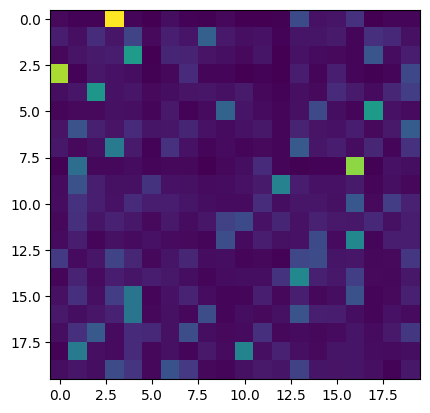

In [69]:
decoder_weights = torch.vstack(store_decoder_weights)
weights = decoder_weights.detach().numpy().mean(axis=0)
plt.imshow(weights)

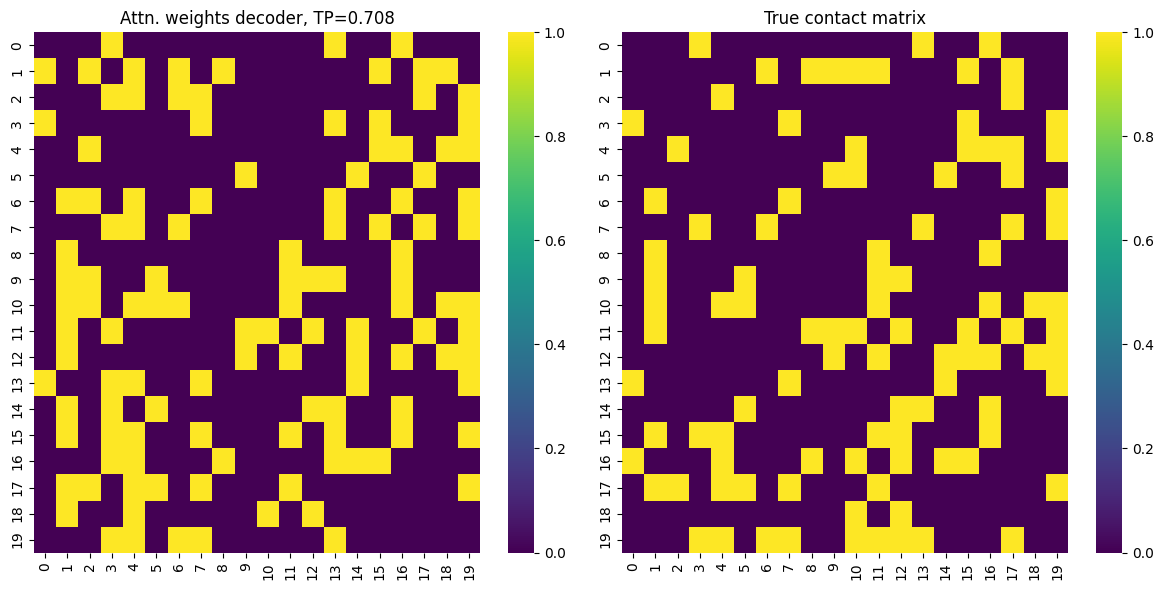

(85, 0.7083333333333334)

In [70]:
decoder_weights = torch.vstack(store_decoder_weights)
weights = decoder_weights.detach().numpy().mean(axis=0)
np.fill_diagonal(weights, 0)
threshold_mi = np.percentile(weights, 70)
weights = np.where(weights > threshold_mi, 1, 0)
plotting_heatmaps(weights, J, f"Attn. weights decoder, TP={round(calculate_true_positives(weights.flatten(), J.flatten())[1],3)}", "True contact matrix")
calculate_true_positives(weights.flatten(), J.flatten())

In [436]:
# To save only the decoder layer weights
#torch.save(model.decoder_layer.state_dict(), 'model_decoder/decoder_weights_experiment_batch.pth')
#torch.save(model.get_cross_attention_weights(), 'model_decoder/transformer_cross_attn_weights_experiment_batch.pth')
#torch.save(model.get_self_attention_weights(), 'model_decoder/transformer_dec_attn_weights_experiment_batch.pth')
#torch.save(model.fc.state_dict(), 'model_decoder/transformer_fc_weights_batch.pth')